<a href="https://colab.research.google.com/github/mirkhalilrehman/Image-Segmentation-UNet-Pytorch/blob/main/UNet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#To be continued not completed

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
class UNet(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(UNet,self).__init__()
    self.enc1 = self.conv_block(in_channels, 64)
    self.enc2 = self.conv_block(64, 128)
    self.enc3 = self.conv_block(128, 256)
    self.enc4 = self.conv_block(256, 512)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.upconv3=nn.ConvTranspose2d(512,256,kernel_size=2, stride=2)
    self.upconv2=nn.ConvTranspose2d(256,128,kernel_size=2, stride=2)
    self.upconv1=nn.ConvTranspose2d(128,64,kernel_size=2, stride=2)

    self.dec1=self.conv_block(512,256)
    self.dec2=self.conv_block(256,128)
    self.dec3=self.conv_block(128,64)
    self.out=nn.Conv2d(64,out_channels=out_channels,kernel_size=1)

  def conv_block(self,in_channels,out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
         nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
    x1=self.enc1(x)
    x2=self.enc2(self.pool(x1))
    x3=self.enc3(self.pool(x2))
    x4=self.enc4(self.pool(x3))

    x=self.upconv3(x4)
    x=torch.cat([x,x3],dim=1)
    x=self.dec1(x)

    x=self.upconv2(x)
    x=torch.cat([x,x2],dim=1)
    x=self.dec2(x)

    x=self.upconv1(x)
    x=torch.cat([x,x1],dim=1)
    x=self.dec3(x)

    return self.out(x)



In [9]:
class LungSegmentation(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_filenames = sorted(os.listdir(image_paths))
        self.mask_filenames = sorted(os.listdir(mask_paths))
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_dir = os.path.join(self.image_paths, self.image_filenames[idx])
        mask_dir = os.path.join(self.mask_paths, self.mask_filenames[idx])

        image = Image.open(image_dir).convert('RGB')
        mask = Image.open(mask_dir).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = mask.squeeze(0)
        mask = torch.where(mask > 0, 1, 0).float()

        return image, mask

In [10]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [18]:
images_path = "/content/drive/MyDrive/lungs/CXR_png"
masks_path = "/content/drive/MyDrive/lungs/masks"

In [19]:
dataset = LungSegmentation(images_path, masks_path, image_transform=image_transform, mask_transform=mask_transform)


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
len(dataset)

703

In [22]:
train_ds,test_ds=train_test_split(dataset,test_size=0.2,random_state=42)

In [23]:

train_ds,val_ds=train_test_split(train_ds,test_size=0.2,random_state=42)

In [24]:
train_dataloader=DataLoader(train_ds,batch_size=16,shuffle=True)
val_dataloader=DataLoader(val_ds,batch_size=16,shuffle=False)
test_dataloader=DataLoader(test_ds,batch_size=16,shuffle=False)

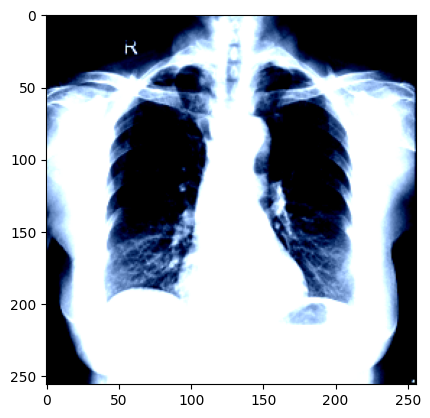

In [28]:
dataiter =iter(train_dataloader)
images,masks=next(dataiter)
img=images[5].permute(1,2,0)
msk=masks[5]
plt.imshow(img)


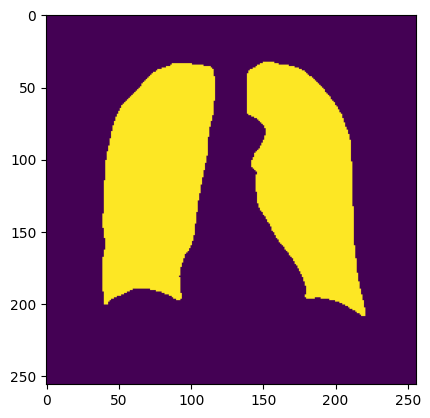

In [29]:
plt.imshow(msk)

In [30]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
model=UNet(3,1)
model=model.to(device)


In [35]:
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [36]:
import numpy as np

In [38]:
train_losses = []
val_losses = []
min_val_loss = np.Inf

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss, val_loss = 0.0, 0.0

    # Training Loop
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Normalize Training Loss
    train_loss = train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}")

    # Validation Loop
    model.eval()
    with torch.no_grad():
        for images, masks in val_dataloader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    # Normalize Validation Loss
    val_loss = val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    # Check if Validation Loss Improved
    if val_loss < min_val_loss:
        print(f"Validation loss decreased from {min_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'lung_segmentation.pt')



Epoch 1/10, Training Loss: 0.1963
Epoch 1/10, Validation Loss: 0.2840
Validation loss decreased from inf to 0.2840. Saving model...
Epoch 2/10, Training Loss: 0.1253
Epoch 2/10, Validation Loss: 0.1225
Validation loss decreased from 0.2840 to 0.1225. Saving model...
Epoch 3/10, Training Loss: 0.1014
Epoch 3/10, Validation Loss: 0.2037
Epoch 4/10, Training Loss: 0.0804
Epoch 4/10, Validation Loss: 0.0779
Validation loss decreased from 0.1225 to 0.0779. Saving model...
Epoch 5/10, Training Loss: 0.0693
Epoch 5/10, Validation Loss: 0.1021
Epoch 6/10, Training Loss: 0.0676
Epoch 6/10, Validation Loss: 0.0626
Validation loss decreased from 0.0779 to 0.0626. Saving model...
Epoch 7/10, Training Loss: 0.0635
Epoch 7/10, Validation Loss: 0.0781
Epoch 8/10, Training Loss: 0.0638
Epoch 8/10, Validation Loss: 0.0630
Epoch 9/10, Training Loss: 0.0603
Epoch 9/10, Validation Loss: 0.0681
Epoch 10/10, Training Loss: 0.0613
Epoch 10/10, Validation Loss: 0.0596
Validation loss decreased from 0.0626 to 

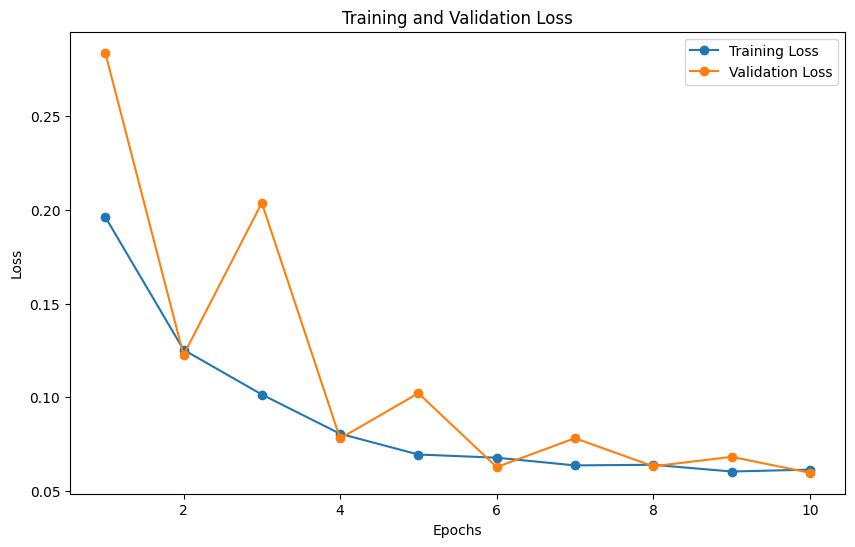

In [39]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

<ipython-input-55-7d5f5957754b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lung_segmentation.pt'))  # Correct file extension


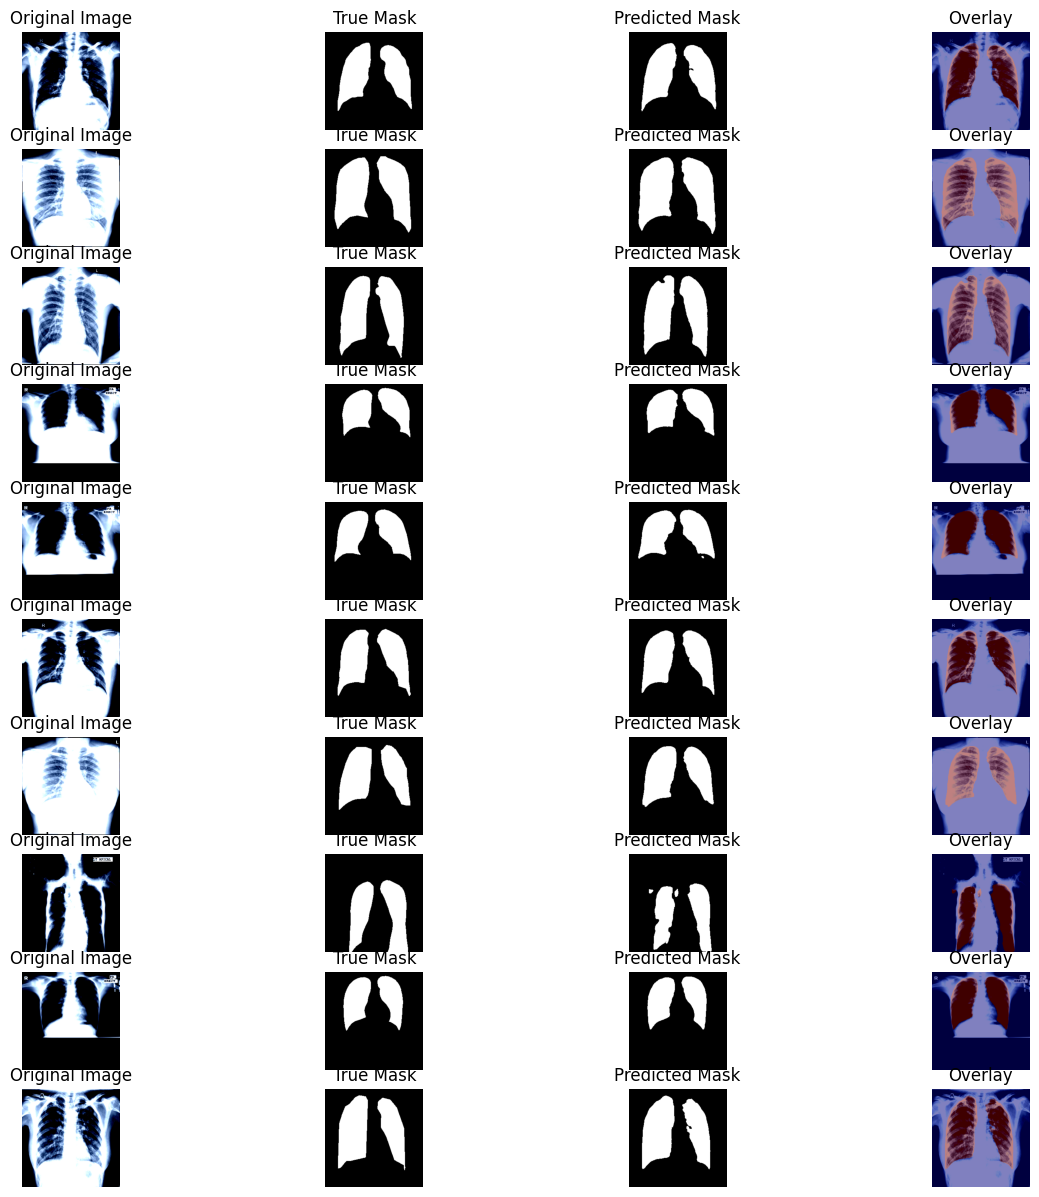

In [55]:
model.load_state_dict(torch.load('lung_segmentation.pt'))  # Correct file extension
model.to(device)
model.eval()

# Initialize sample counter
sample_count = 0
num_samples=10
plt.figure(figsize=(15, 15))
# Loop through test loader to visualize predictions
for images, true_masks in test_dataloader:
    # Move images and masks to the same device as the model
    images = images.to(device)
    true_masks = true_masks.to(device)

    with torch.no_grad():
        # Get model predictions
        pred_masks = model(images)
        pred_masks = torch.sigmoid(pred_masks).cpu().numpy()

    for i in range(images.size(0)):
        if sample_count >= num_samples:
            break

        # Prepare images and masks for plotting
        image = images[i].cpu().permute(1, 2, 0).numpy()
        true_mask = true_masks[i].cpu().squeeze().numpy()
        pred_mask = pred_masks[i].squeeze()

        # Binarize prediction mask
        pred_mask = (pred_mask > 0.5).astype(float)

        # Plot original image
        plt.subplot(num_samples, 4, sample_count * 4 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        # Plot true mask
        plt.subplot(num_samples, 4, sample_count * 4 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Plot predicted mask
        plt.subplot(num_samples, 4, sample_count * 4 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        # Overlay predicted mask on image
        plt.subplot(num_samples, 4, sample_count * 4 + 4)
        plt.imshow(image)
        plt.imshow(pred_mask, cmap="jet", alpha=0.5)
        plt.title("Overlay")
        plt.axis("off")

        # Increment the sample counter
        sample_count += 1

# Display all plotted images

plt.show()

In [52]:
import numpy as np

def calculate_metrics(pred_masks, true_masks):
    """
    Calculate Pixel Accuracy, IoU, and Dice Coefficient.

    Args:
        pred_masks (numpy.ndarray): Predicted masks (binarized).
        true_masks (numpy.ndarray): Ground truth masks (binarized).

    Returns:
        dict: Dictionary of metrics (Pixel Accuracy, IoU, Dice).
    """
    assert pred_masks.shape == true_masks.shape, "Shapes of predicted and true masks must match."

    metrics = {}

    # Flatten masks for easier computation
    pred_flat = pred_masks.flatten()
    true_flat = true_masks.flatten()

    # Pixel Accuracy
    pixel_accuracy = np.mean(pred_flat == true_flat)
    metrics['Pixel Accuracy'] = pixel_accuracy

    # Intersection and Union
    intersection = np.sum((pred_flat == 1) & (true_flat == 1))
    union = np.sum((pred_flat == 1) | (true_flat == 1))

    # IoU
    iou = intersection / union if union > 0 else 0.0
    metrics['IoU'] = iou

    # Dice Coefficient
    dice = (2 * intersection) / (np.sum(pred_flat) + np.sum(true_flat)) if (np.sum(pred_flat) + np.sum(true_flat)) > 0 else 0.0
    metrics['Dice Coefficient'] = dice

    return metrics

# Example usage within your test loop
all_metrics = []

for images, true_masks in test_dataloader:
    images = images.to(device)
    true_masks = true_masks.to(device)

    with torch.no_grad():
        pred_masks = model(images)
        pred_masks = torch.sigmoid(pred_masks).cpu().numpy()

    # Ensure masks are binary
    pred_masks = (pred_masks > 0.5).astype(float)
    true_masks = true_masks.cpu().numpy()

    # Calculate metrics for each batch
    for i in range(images.size(0)):
        # Ensure shape consistency
        pred_mask = np.squeeze(pred_masks[i])
        true_mask = np.squeeze(true_masks[i])

        if pred_mask.shape != true_mask.shape:
            # Resize prediction if required
            pred_mask = cv2.resize(pred_mask, (true_mask.shape[1], true_mask.shape[0]))

        batch_metrics = calculate_metrics(pred_mask, true_mask)
        all_metrics.append(batch_metrics)


# Average metrics over all samples
average_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
print("Average Metrics:", average_metrics)


Average Metrics: {'Pixel Accuracy': 0.9789892967711104, 'IoU': 0.9235345303215754, 'Dice Coefficient': 0.9596986869435759}
